In [14]:
!pip install pmdarima

  Using cached pmdarima-1.8.2-cp38-cp38-win_amd64.whl (596 kB)


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import math
import numpy as np

In [13]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('E:\OneDrive - Indian Institute of Technology Bombay\Kcluster_project\CIPLA.NS.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(data.mean())

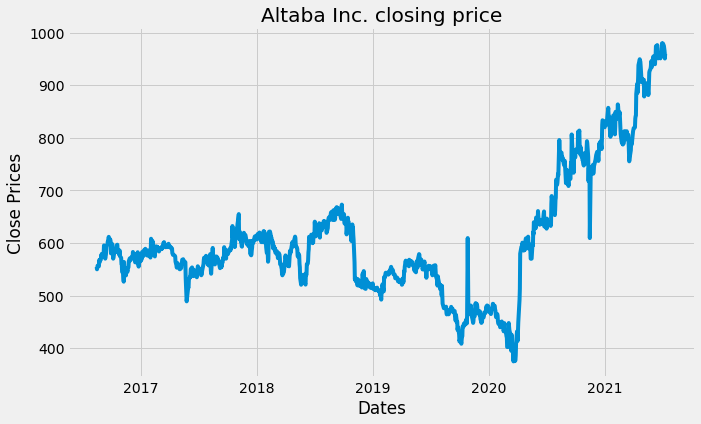

In [14]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Altaba Inc. closing price')
plt.show()

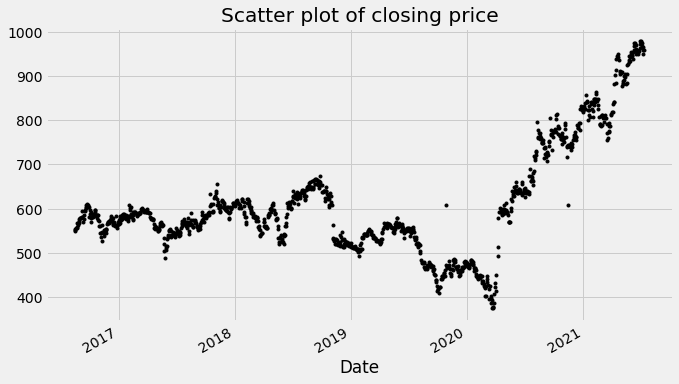

In [15]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

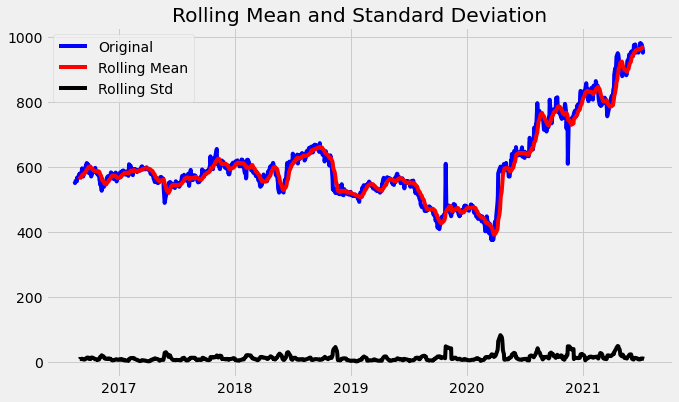

Results of dickey fuller test
Test Statistics                  -0.056777
p-value                           0.953577
No. of lags used                  2.000000
Number of observations used    1208.000000
critical value (1%)              -3.435775
critical value (5%)              -2.863936
critical value (10%)             -2.568045
dtype: float64


In [16]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

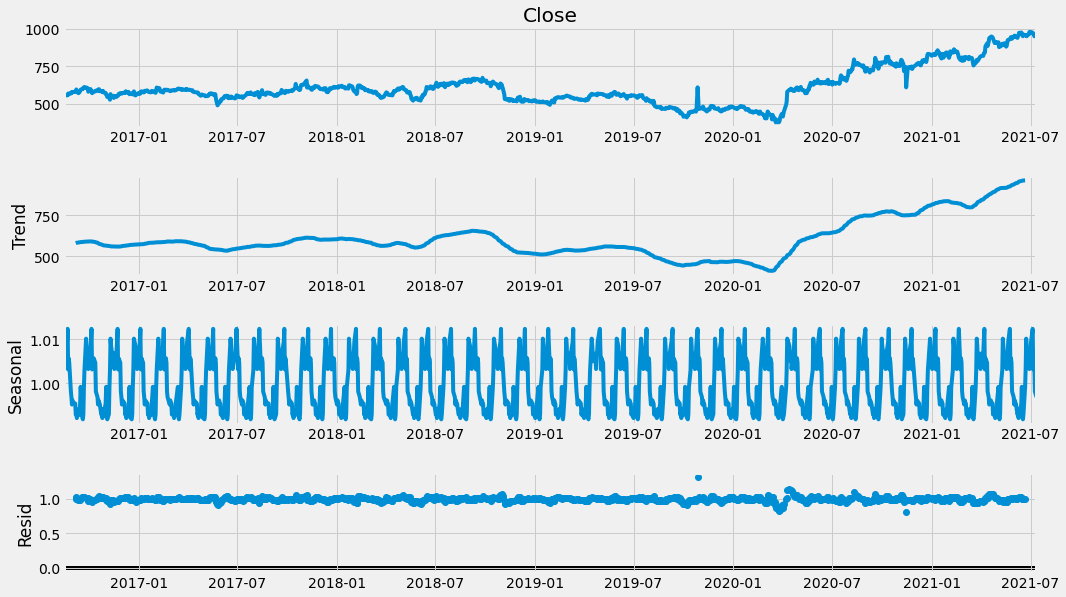

In [17]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


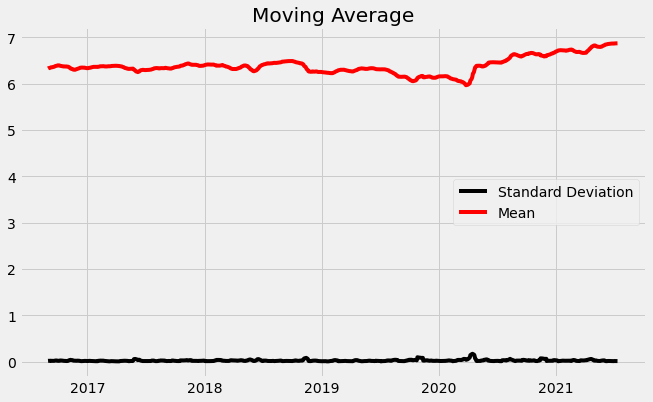

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

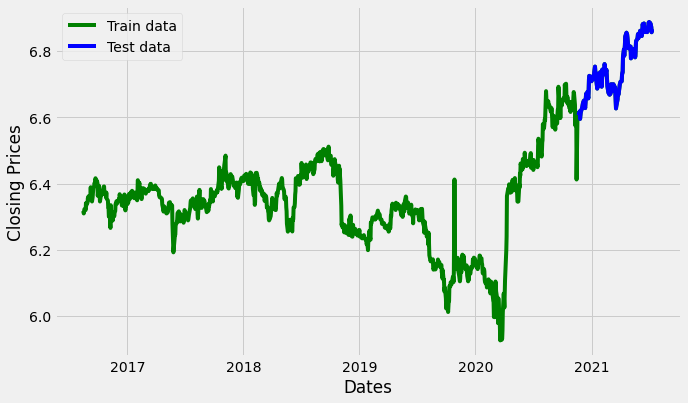

In [20]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.87)], df_log[int(len(df_log)*0.87):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [22]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4934.019, Time=2.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4978.824, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4981.582, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4935.867, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4979.507, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4979.547, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4977.601, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4983.322, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4981.249, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4981.287, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4980.591, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4979.345, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.326 seconds
                               SARIMAX Results                              

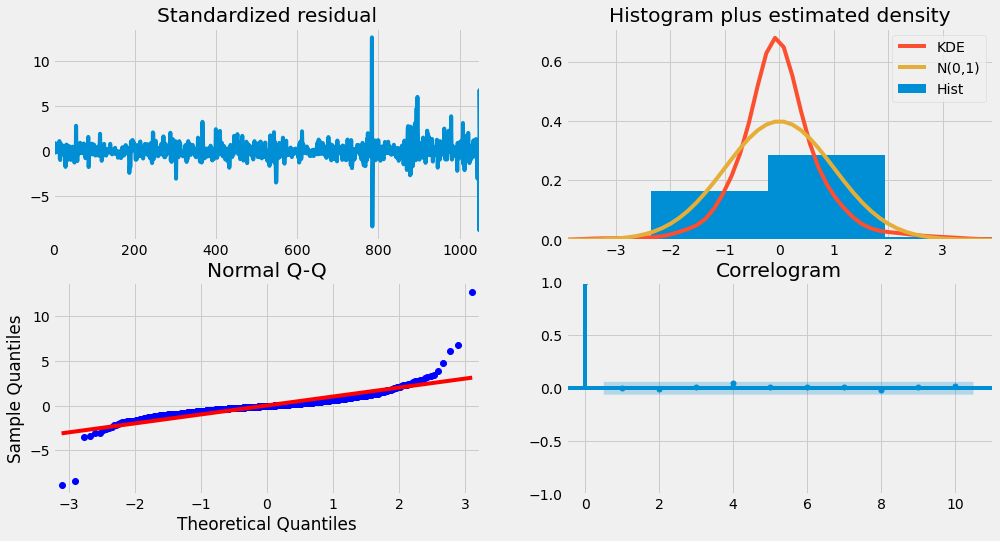

In [23]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [25]:
model = ARIMA(train_data, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1052
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2493.791
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 13 Aug 2021   AIC                          -4981.583
Time:                        13:24:55   BIC                          -4966.707
Sample:                             1   HQIC                         -4975.943
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.510      0.610      -0.001       0.001
ma.L1.D.Close    -0.2194      0.030     -7.352      0.000      -0.278      -0.161
                                    Root

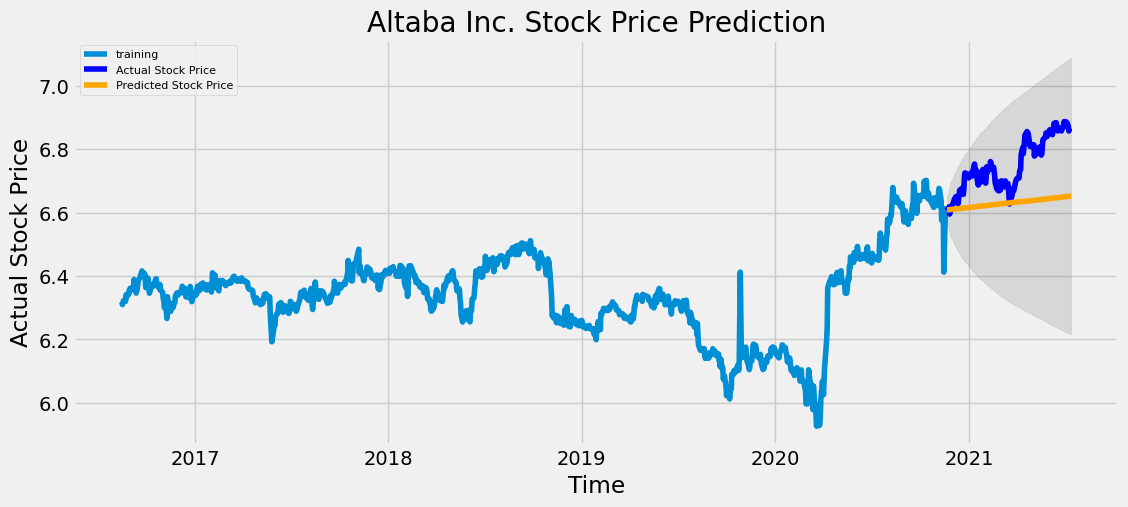

In [28]:
# Forecast
fc, se, conf = fitted.forecast(158,alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.019908502454533305
MAE: 0.12194911006222584
RMSE: 0.14109749272943622
MAPE: 0.017936894684498713
